In [20]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
spam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
nonspam_1_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
nonspam_2_path = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
spam_cat =1 
ham_cat =0
data_json_file='SpamData/01_Processing/email-text-data.json'

In [22]:
#Reading files
eg_file = 'SpamData/01_Processing/practice_email.txt'
stream=open(eg_file,encoding="latin-1")
message=stream.read()
stream.close()

In [23]:
stream=open(eg_file)
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Creating Pandas DataFrame of email bodies

In [24]:
def email_body_generator(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            filepath = join(root,file_name)
            stream = open(filepath, encoding="latin-1")
            is_body = False
            lines = []
            for lines in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                email_body='\n'.join(lines)
                yield file_name,email_body
stream.close()

In [25]:
def df_from_directory(path,classification):
    rows=[]
    rows_names=[]
    for file_names,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        rows_names.append(file_names)
    return pd.DataFrame(rows,index=rows_names)

In [26]:
#for spam emails
spam_emails = df_from_directory(spam_1_path,spam_cat)
spam_emails = pd.concat([spam_emails,df_from_directory(spam_2_path,spam_cat)])
print(spam_emails.shape)

(268601, 2)


In [27]:
#for non-spam emails
ham_emails = df_from_directory(nonspam_1_path,ham_cat)
ham_emails = pd.concat([ham_emails, df_from_directory(nonspam_2_path,ham_cat)])
print(ham_emails.shape)

(329266, 2)


In [28]:
#concating both spam and non-emails
data = pd.concat([spam_emails,ham_emails])
print('shape of the whole dataframe',data.shape)

shape of the whole dataframe (597867, 2)


## Data Cleaning: checking for missing values

In [29]:
# null_string =""
# none_string =None
# print(type(null_string))
# print(type(none_string))

In [30]:
#checking none values
print((data.MESSAGE.str.len()==0).values.any())
print((data.MESSAGE.str.len()==0).sum())
#checking null values
print(data.MESSAGE.isnull().values.any())
print(data.MESSAGE.isnull().sum())

False
0
False
0


In [31]:
# data.MESSAGE.str.len()
print(data.shape)
print(type(data))

(597867, 2)
<class 'pandas.core.frame.DataFrame'>


In [32]:
type(data.MESSAGE.str.len()==0)
print(data[data.MESSAGE.str.len()==0].index)

Index([], dtype='object')


In [33]:
#Adding Document IDs to track Email in dataset
document_ids=range(0,len(data.index))
data['DOC_ID']=document_ids
data['FILENAME']=data.index
data.set_index('DOC_ID',inplace=True)
data.head()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
0,F\nr\no\nm\n \n1\n2\na\n1\nm\na\ni\nl\nb\no\nt...,1,00001.7848dde101aa985090474a91ec93fcf0
1,R\ne\nt\nu\nr\nn\n-\nP\na\nt\nh\n:\n \n<\n1\n2...,1,00001.7848dde101aa985090474a91ec93fcf0
2,D\ne\nl\ni\nv\ne\nr\ne\nd\n-\nT\no\n:\n \nz\nz...,1,00001.7848dde101aa985090474a91ec93fcf0
3,R\ne\nc\ne\ni\nv\ne\nd\n:\n \nf\nr\no\nm\n \nl...,1,00001.7848dde101aa985090474a91ec93fcf0
4,\t\nb\ny\n \np\nh\no\nb\no\ns\n.\nl\na\nb\ns\n...,1,00001.7848dde101aa985090474a91ec93fcf0


In [34]:
data.tail()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
597862,I\nr\ni\ns\nh\n \nL\ni\nn\nu\nx\n \nU\ns\ne\nr...,0,01400.f897f0931e461e7b2e964d28e927c35e
597863,h\nt\nt\np\n:\n/\n/\nw\nw\nw\n.\nl\ni\nn\nu\nx...,0,01400.f897f0931e461e7b2e964d28e927c35e
597864,L\ni\ns\nt\n \nm\na\ni\nn\nt\na\ni\nn\ne\nr\n:...,0,01400.f897f0931e461e7b2e964d28e927c35e
597865,\n,0,01400.f897f0931e461e7b2e964d28e927c35e
597866,\n,0,01400.f897f0931e461e7b2e964d28e927c35e


In [35]:
#Saving Files as json
data.to_json(data_json_file)

# Data Visualization

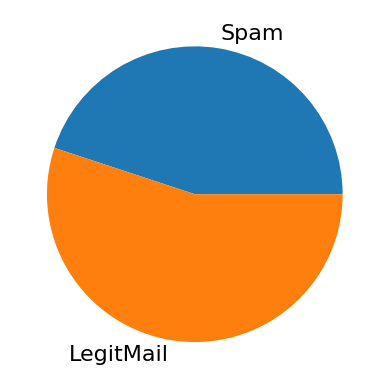

In [36]:
#Number of Spam Messages Visualised (Pie Charts)
data.CATEGORY.value_counts()
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
category_names = ['Spam','LegitMail']
sizes = [amount_of_spam, amount_of_ham]
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':16})
plt.show()

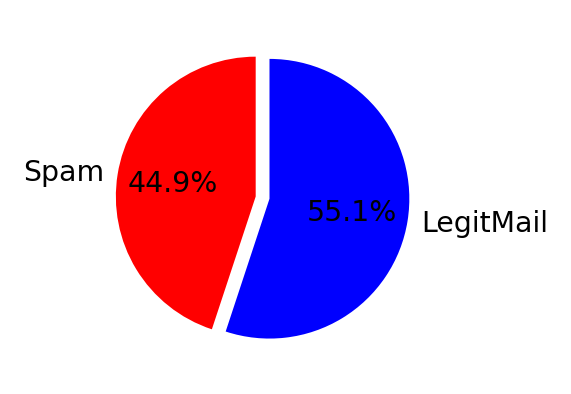

In [37]:
#Number of Spam Messages Visualised (Pie Charts)
data.CATEGORY.value_counts()
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
category_names = ['Spam','LegitMail']
colours=['red','blue']
explode=[0,0.1]
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2,2),dpi=227)
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':9},colors=colours,explode=[0,0.1],autopct ='%1.1f%%',startangle=90)
plt.show()

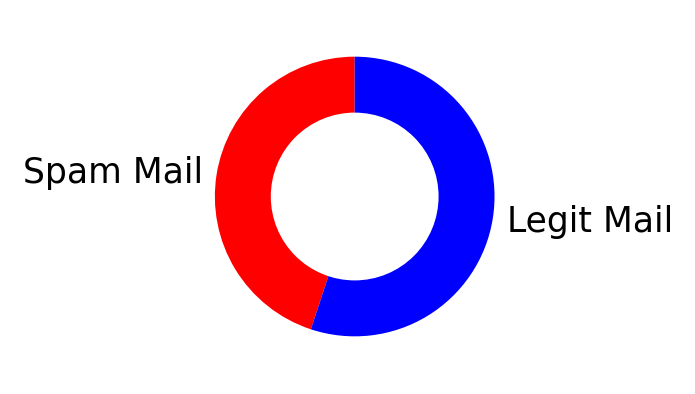

In [38]:
#Donought Chart
#Drawing Circle
category_names = ['Spam Mail','Legit Mail']
colours=['red','blue']
explode=[0,0]
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2,2),dpi=227)
plt.pie(x=sizes,labels=category_names,textprops={'fontsize':11},colors=colours,explode=explode,startangle=90)
#autopct ='%1.1f%%'
center_circle = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(center_circle)
plt.show()